<a href="https://colab.research.google.com/github/unprobable-x/payout-simulations/blob/main/HLR_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
from google.cloud import bigquery
import numpy as np
import random
from scipy.stats import norm

# Authenticate and create the PyDrive client.
auth.authenticate_user()
print('Authenticated')

Authenticated


In [4]:
sql = """
select daily_amount, platform_index as platform_number, date_index as day_of_year
FROM stripe.hlr_time_series
"""

project_id = 'modern-sublime-215302'
client = bigquery.Client(project = project_id)
df = client.query(sql).to_dataframe()

In [ ]:
median_list = []
for i in range(1,1000):
  df_list = []
  for i in range(15, 15 + 70 * 5, 70):
    is_zero = np.random.binomial(1, 0.8)
    if is_zero == 0:
      df_new = pd.DataFrame()
      df_new['day_of_year'] = range(1, 366)
      df_new['daily_amount'] = np.zeros(365)
    else:
      curve_index = random.randint(1, 16)
      ramp_up_time = np.random.binomial(1, 0.7)
      if ramp_up_time == 1:
        ramp_up_time = 0
      elif ramp_up_time == 0:
        ramp_up_time = 45
      curve_multiplier = 0.8 + 0.4 * random.random()
      df_part1 = pd.DataFrame()
      df_part1['day_of_year'] = range(1, i + ramp_up_time + 1)
      df_part1['daily_amount'] = np.zeros(i + ramp_up_time)
      df_part2 = df.loc[df['platform_number'] == curve_index]
      df_part2['daily_amount'] = df_part2['daily_amount'] * curve_multiplier
      df_part2['day_of_year'] = df_part2['day_of_year'] + i + ramp_up_time
      df_part2 = df_part2.drop('platform_number', axis=1)
      df_new = pd.concat([df_part1, df_part2])
    df_list.append(df_new)
  df_final = pd.concat(df_list)
  df_final = df_final.loc[df_final['day_of_year'] <= 365]
  df_final = df_final.groupby('day_of_year', as_index=False)['daily_amount'].sum()
  median_daily_amount = df_final['daily_amount'].median()
  median_list.append(median_daily_amount)

In [6]:
import numpy as np

median_list = np.array(median_list)
median = np.median(median_list)
q1 = np.percentile(median_list, 25)
q3 = np.percentile(median_list, 75)

print("Median:", median)
print("25th percentile:", q1)
print("75th percentile:", q3)

Median: 88630.28679215779
25th percentile: 0.0
75th percentile: 837505.278903899


<Axes: >

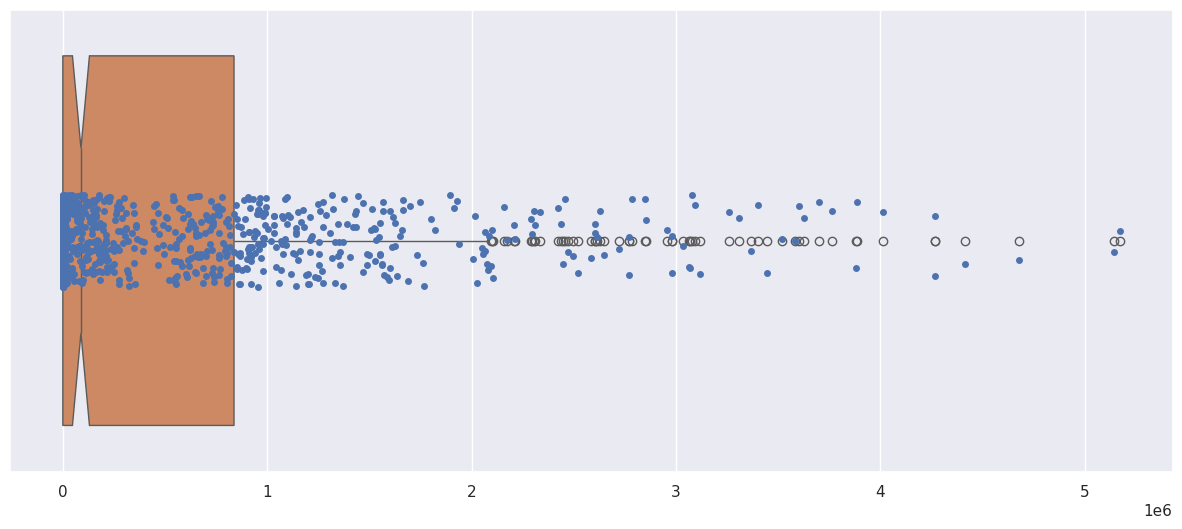

In [7]:
import seaborn as sns

sns.set(rc={'figure.figsize':(15,6)})
sns.stripplot(x = median_list, orient='h')
sns.boxplot(x = median_list, orient='h', notch=True, showcaps = False)